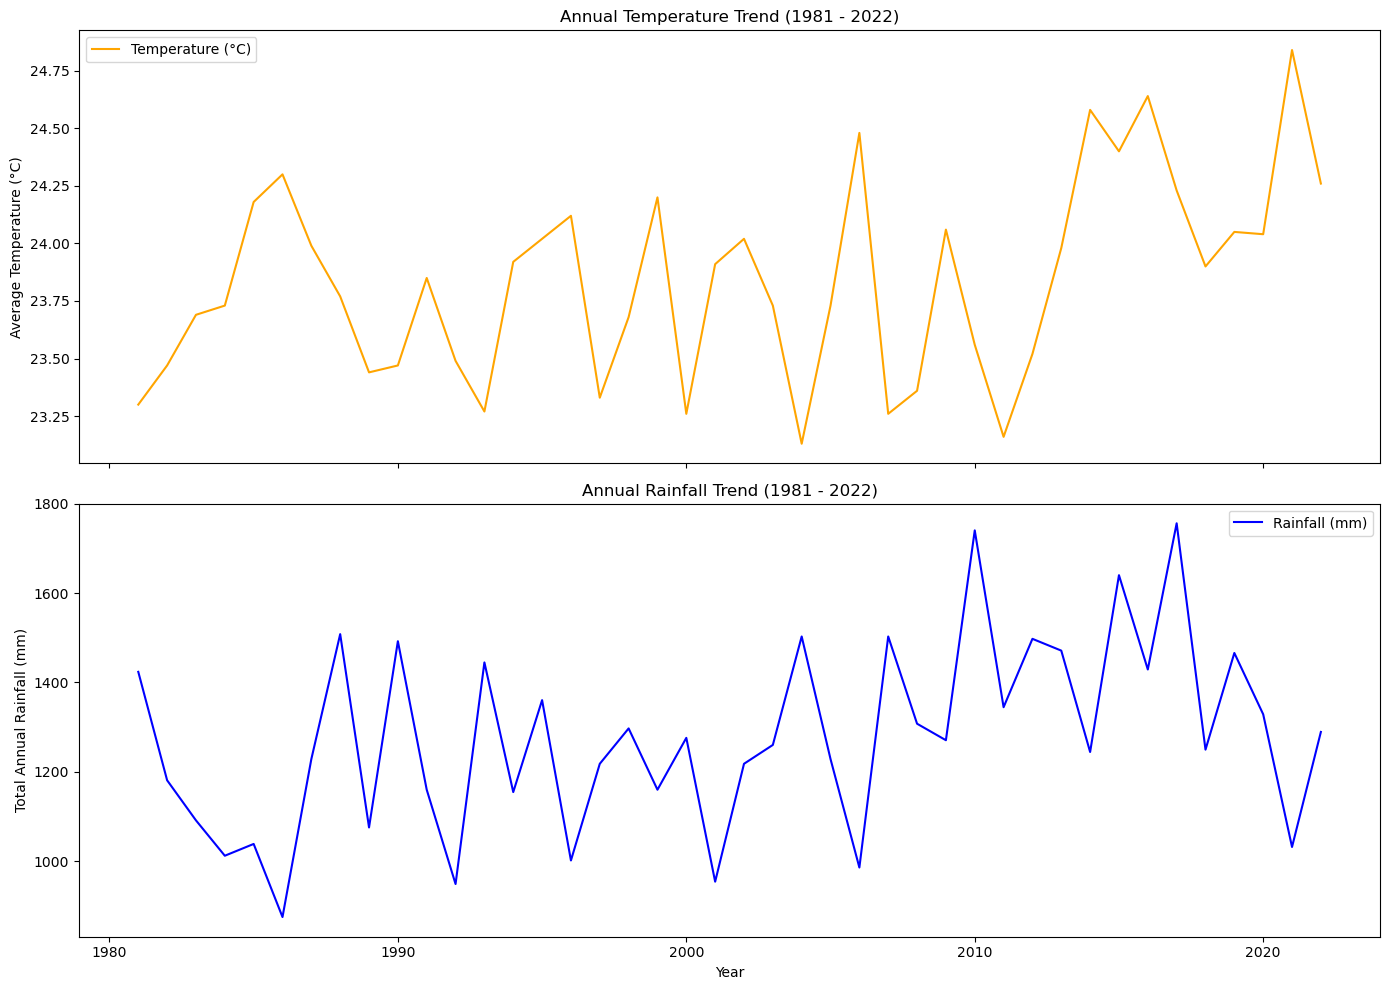

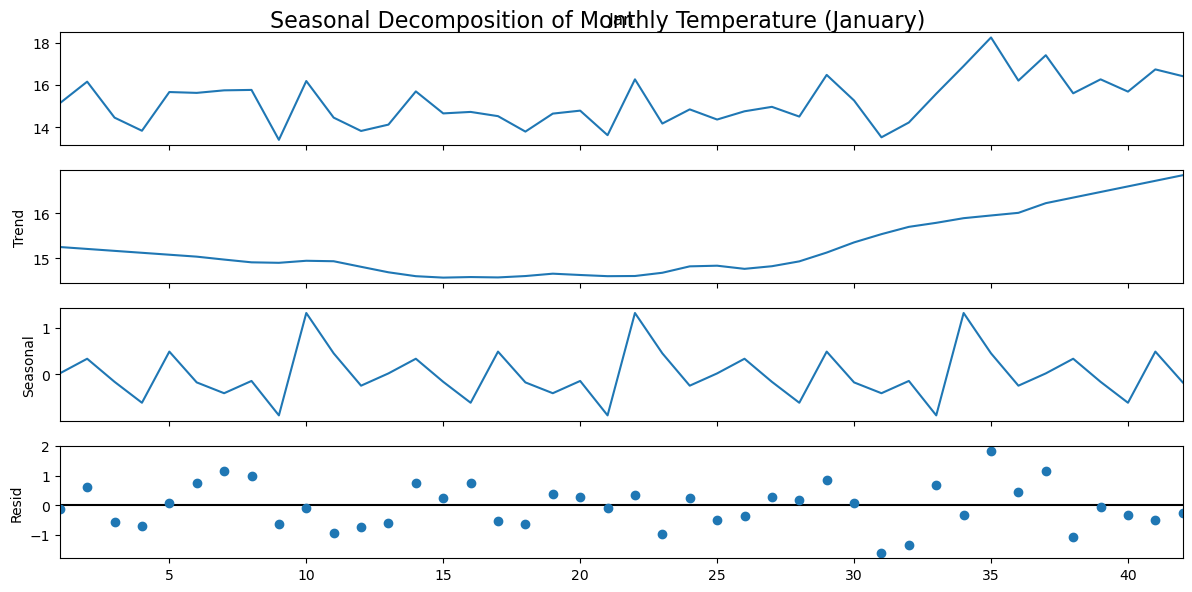

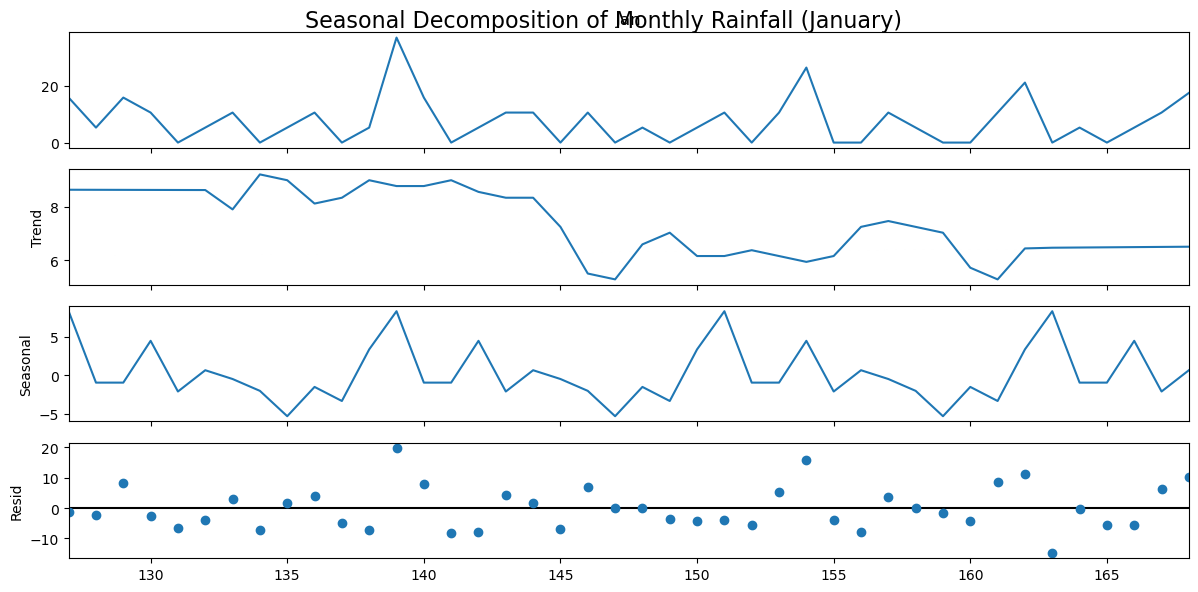

Temperature Anomalies:
     Year  Annual
41  2021   24.84

Rainfall Anomalies:
      Year   Annual
156  2010  1740.23
163  2017  1756.05
Polynomial Regression Mean Squared Error: 46966.84
Temperature Forecast for Next 5 Years:
 Annual           mean   mean_se  mean_ci_lower  mean_ci_upper
2023-01-01  24.155994  0.406689      23.358898      24.953089
2024-01-01  24.126812  0.437870      23.268602      24.985022
2025-01-01  24.118624  0.447784      23.240984      24.996264
2026-01-01  24.116327  0.453932      23.226636      25.006018
2027-01-01  24.115682  0.459156      23.215753      25.015611


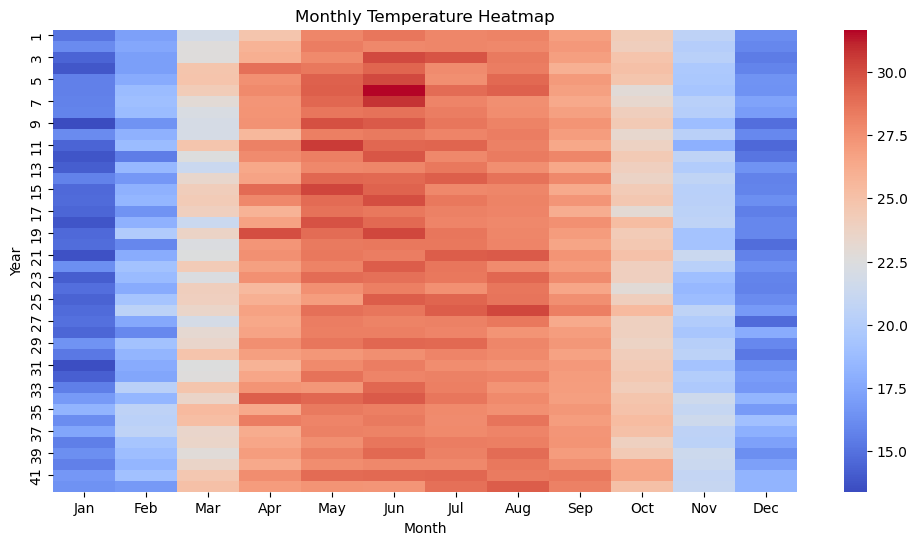

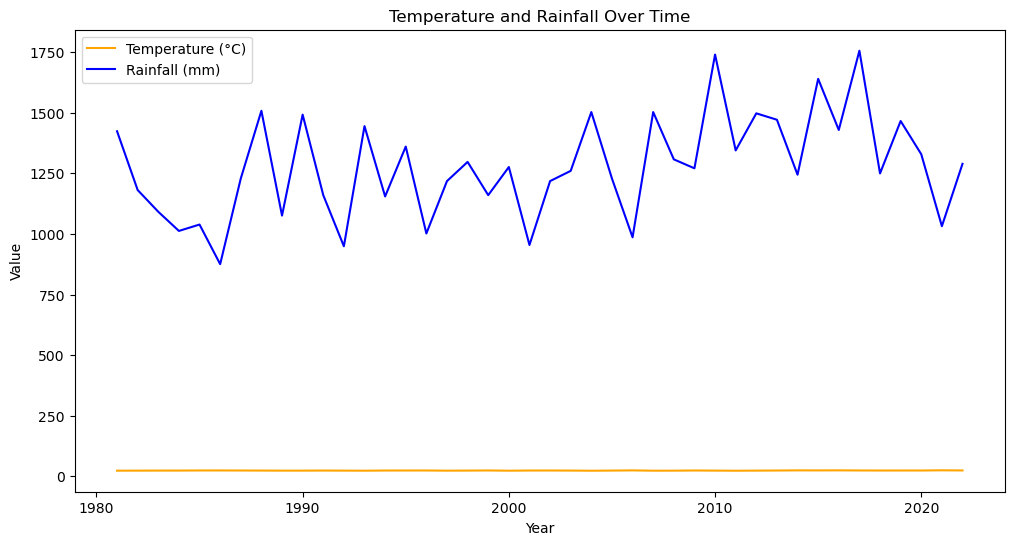

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
file_path = 'Climate.csv'  # Update with your file path
df = pd.read_csv(file_path, skiprows=11)

# Rename columns for easier access and remove redundant header row
df.columns = ['Parameter', 'Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual']
df = df[1:]

# Convert columns to appropriate data types
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
months_and_annual = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual']
df[months_and_annual] = df[months_and_annual].apply(pd.to_numeric, errors='coerce')

# Separate temperature (TS) and rainfall (PRECTOTCORR_SUM) data
df_temperature = df[df['Parameter'] == 'TS'].copy()
df_rainfall = df[df['Parameter'] == 'PRECTOTCORR_SUM'].copy()

# STEP 1: Annual Trend Analysis
plt.rcParams['figure.figsize'] = (12, 6)

# Plot annual trends for temperature and rainfall
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Temperature trend plot
axes[0].plot(df_temperature['Year'], df_temperature['Annual'], color='orange', label='Temperature (°C)')
axes[0].set_title('Annual Temperature Trend (1981 - 2022)')
axes[0].set_ylabel('Average Temperature (°C)')
axes[0].legend()

# Rainfall trend plot
axes[1].plot(df_rainfall['Year'], df_rainfall['Annual'], color='blue', label='Rainfall (mm)')
axes[1].set_title('Annual Rainfall Trend (1981 - 2022)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Annual Rainfall (mm)')
axes[1].legend()

plt.tight_layout()
plt.show()

# STEP 2: Seasonal Decomposition
decompose_temp = seasonal_decompose(df_temperature['Jan'], period=12, model='additive', extrapolate_trend='freq')
decompose_temp.plot().suptitle('Seasonal Decomposition of Monthly Temperature (January)', fontsize=16)
plt.show()

decompose_rain = seasonal_decompose(df_rainfall['Jan'], period=12, model='additive', extrapolate_trend='freq')
decompose_rain.plot().suptitle('Seasonal Decomposition of Monthly Rainfall (January)', fontsize=16)
plt.show()

# STEP 3: Anomaly Detection
temp_mean, temp_std = df_temperature['Annual'].mean(), df_temperature['Annual'].std()
temp_anomalies = df_temperature[(df_temperature['Annual'] > temp_mean + 2 * temp_std) |
                                (df_temperature['Annual'] < temp_mean - 2 * temp_std)]

rain_mean, rain_std = df_rainfall['Annual'].mean(), df_rainfall['Annual'].std()
rain_anomalies = df_rainfall[(df_rainfall['Annual'] > rain_mean + 2 * rain_std) |
                             (df_rainfall['Annual'] < rain_mean - 2 * rain_std)]

print("Temperature Anomalies:\n", temp_anomalies[['Year', 'Annual']])
print("\nRainfall Anomalies:\n", rain_anomalies[['Year', 'Annual']])

# STEP 4: Advanced Modeling
X = df_temperature['Annual'].values.reshape(-1, 1)  # Temperature as feature
y = df_rainfall['Annual'].values  # Rainfall as target

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Polynomial Regression Mean Squared Error: {mse:.2f}')

# ARIMA for Time Series Forecasting on temperature data
temperature_series = df_temperature.set_index(pd.to_datetime(df_temperature['Year'], format='%Y'))['Annual']

# Fit ARIMA model
arima_model = ARIMA(temperature_series, order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecast the next 5 years
forecast = arima_result.get_forecast(steps=5)
forecast_df = forecast.summary_frame()
print("Temperature Forecast for Next 5 Years:\n", forecast_df)

# STEP 5: Enhanced Visualizations
monthly_temps = df_temperature[months_and_annual[:12]].astype(float)
sns.heatmap(monthly_temps, cmap='coolwarm', annot=False)
plt.title("Monthly Temperature Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_temperature['Year'], df_temperature['Annual'], color='orange', label='Temperature (°C)')
plt.plot(df_rainfall['Year'], df_rainfall['Annual'], color='blue', label='Rainfall (mm)')
plt.title("Temperature and Rainfall Over Time")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()